In [25]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from src.models.win_prediction import agg_by_pos

In [5]:
#team_df = pd.read_csv('../data/external/NBA_team_stats_1979-2024.csv', header=1)
#player_df = pd.read_csv('../data/processed/player_data_clean.csv')
#df = agg_by_pos(team_df, player_df)

OSError: Cannot save file into a non-existent directory: '../../data/interim'

In [ ]:
#pca_model_path = '../models'
#df = pd.read_csv('../data/processed/player_data_clean.csv')
#df = agg_by_pos(df, team_df='../data/interim/NBA_team_stats_1979-2024_clean.csv', save_file=False, use_pca=False)

In [6]:
df = pd.read_csv('../data/processed/roster_stats.csv')

In [8]:
df.head()

,full_season,tm,pos_PG_fg_per_100_poss,pos_PG_fga_per_100_poss,pos_PG_x3p_per_100_poss,pos_PG_x3pa_per_100_poss,pos_PG_x2p_per_100_poss,pos_PG_x2pa_per_100_poss,pos_PG_ft_per_100_poss,pos_PG_fta_per_100_poss,...,pos_C_dws,pos_C_ws,pos_C_ws_48,pos_C_obpm,pos_C_dbpm,pos_C_bpm,pos_C_vorp,Season,Team,W/L%
0,1997-98,BOS,7.260762,17.634528,2.348459,6.420697,4.870058,11.213831,4.594588,5.578351,...,1.246365,2.444382,0.103279,-3.005288,-0.304627,-3.309914,-0.352974,1997-98,BOS,0.439
1,1997-98,CHH,7.210241,15.574443,1.357956,4.001975,5.852285,11.572468,3.628197,4.573456,...,3.583232,6.709271,0.121801,0.385968,1.777406,2.071935,3.017477,1997-98,CHH,0.622
2,1997-98,CHI,5.968318,13.870941,1.464821,4.228767,4.503498,9.708744,2.167735,3.068318,...,0.717859,1.224547,0.077017,-3.796097,-0.156843,-3.929552,-0.357671,1997-98,CHI,0.756
3,1997-98,CLE,4.000000,8.200000,1.100000,2.500000,3.000000,5.700000,3.000000,3.200000,...,3.708125,6.085096,0.126054,-1.569982,0.053047,-1.579689,0.796386,1997-98,CLE,0.573
4,1997-98,DAL,6.590216,17.010461,2.510403,6.967061,4.090458,10.037456,2.986298,3.922465,...,1.660139,1.539976,0.052147,-2.863951,0.772142,-2.057897,0.151702,1997-98,DAL,0.244


## Simple Linear Regression

In [7]:
X, y = df.drop(columns='W%'), df['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

KeyError: "['W%'] not found in axis"

## Random Forest

In [ ]:
rf_reg = RandomForestRegressor(random_state=41)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

In [ ]:
y_train_pred = rf_reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('Train Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

## Gradient Boosted Trees

In [ ]:
cat_reg = CatBoostRegressor(iterations=1000,
                            learning_rate=0.01,
                            depth=6, l2_leaf_reg=3,
                            bagging_temperature=1,
                            early_stopping_rounds=50,
                            loss_function='RMSE',
                            random_state=41,
                            logging_level='Silent',
                            allow_writing_files=False)
cat_reg.fit(X_train, y_train)
y_pred = cat_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

In [ ]:
y_train_pred = cat_reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('Train Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual W/L%')
plt.ylabel('Predicted W/L%')
plt.title('Actual vs Predicted W/L%')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

## Ridge Regression

In [ ]:
X, y = df.drop(columns='W%'), df['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
ridge_reg = Ridge(alpha=10).fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Alternate Training Set (Pazin's)

In [ ]:
data_path = '../data/interim/NBA_team_player_stats_Year_Adjusted.csv'
df = pd.read_csv(data_path)
X = df.drop(columns=['W/L%', 'Season', 'Team'])
y = df['W/L%']

## Ridge Regression GridSearchCV

In [ ]:
ridge_params = {'alpha': [1, 10, 100, 1000, 10000, 100000, 1000000]}
ridge = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5, n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

In [ ]:
ridge_grid_search.best_estimator_

In [ ]:
model = Ridge(alpha=10000, random_state=41)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('Train Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

joblib.dump(model, '../models/win_prediction.pkl')

## GridSearch Boosted Trees

In [ ]:
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 2, 3],
    'random_strength': [1, 2, 5]
}
catboost_model = CatBoostRegressor(random_state=41, logging_level='Silent', allow_writing_files=False, loss_function='RMSE')
catboost_gridsearch = GridSearchCV(estimator=catboost_model, param_grid=parameters, cv=3, n_jobs=-1, verbose=2)
catboost_gridsearch.fit(X_train, y_train)

best_params = catboost_gridsearch.best_params_
best_model = catboost_gridsearch.best_estimator_

print(f'Best Parameters: {best_params}')

In [9]:
training_df = pd.read_csv('../data/processed/roster_stats.csv')

In [10]:
training_df.head()

,full_season,tm,pos_PG_fg_per_100_poss,pos_PG_fga_per_100_poss,pos_PG_x3p_per_100_poss,pos_PG_x3pa_per_100_poss,pos_PG_x2p_per_100_poss,pos_PG_x2pa_per_100_poss,pos_PG_ft_per_100_poss,pos_PG_fta_per_100_poss,...,pos_C_dws,pos_C_ws,pos_C_ws_48,pos_C_obpm,pos_C_dbpm,pos_C_bpm,pos_C_vorp,Season,Team,W/L%
0,1997-98,BOS,7.260762,17.634528,2.348459,6.420697,4.870058,11.213831,4.594588,5.578351,...,1.246365,2.444382,0.103279,-3.005288,-0.304627,-3.309914,-0.352974,1997-98,BOS,0.439
1,1997-98,CHH,7.210241,15.574443,1.357956,4.001975,5.852285,11.572468,3.628197,4.573456,...,3.583232,6.709271,0.121801,0.385968,1.777406,2.071935,3.017477,1997-98,CHH,0.622
2,1997-98,CHI,5.968318,13.870941,1.464821,4.228767,4.503498,9.708744,2.167735,3.068318,...,0.717859,1.224547,0.077017,-3.796097,-0.156843,-3.929552,-0.357671,1997-98,CHI,0.756
3,1997-98,CLE,4.000000,8.200000,1.100000,2.500000,3.000000,5.700000,3.000000,3.200000,...,3.708125,6.085096,0.126054,-1.569982,0.053047,-1.579689,0.796386,1997-98,CLE,0.573
4,1997-98,DAL,6.590216,17.010461,2.510403,6.967061,4.090458,10.037456,2.986298,3.922465,...,1.660139,1.539976,0.052147,-2.863951,0.772142,-2.057897,0.151702,1997-98,DAL,0.244


In [11]:
X = training_df.drop(columns=['full_season', 'tm', 'Season', 'Team', 'W/L%'])
y = training_df['W/L%']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
ridge_reg = Ridge(alpha=10000).fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Test Scores
Mean Squared Error: 0.010815828662251392
R^2 Score: 0.4952393395285051


In [13]:
joblib.dump(ridge_reg, '../models/win_prediction.pkl')

['../models/win_prediction.pkl']

In [14]:
model = joblib.load('../models/win_prediction.pkl')
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Test Scores
Mean Squared Error: 0.010815828662251392
R^2 Score: 0.4952393395285051


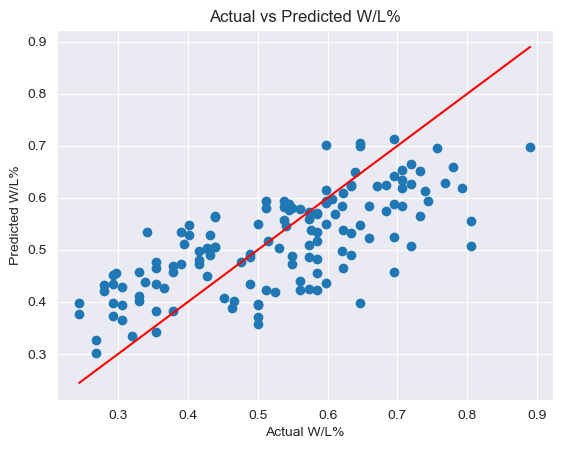

In [15]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual W/L%')
plt.ylabel('Predicted W/L%')
plt.title('Actual vs Predicted W/L%')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [22]:
features = training_df.drop(columns=['full_season', 'tm', 'Season', 'Team', 'W/L%']).columns.to_list()
importances = list(abs(model.coef_))
feat_importance_df = pd.DataFrame({'Feature': features, 'Abs. Coeff.': importances})

In [24]:
feat_importance_df.sort_values('Abs. Coeff.', ascending=False)

,Feature,Abs. Coeff.
17,pos_PG_o_rtg,3.262650e-03
77,pos_SG_d_rtg,3.041538e-03
18,pos_PG_d_rtg,3.008731e-03
195,pos_SF_d_rtg,2.744912e-03
136,pos_PF_d_rtg,2.138771e-03
...,...,...
227,pos_SF_usg_percent,9.059156e-07
258,pos_C_percent_fga_from_x3_10_range,4.646910e-07
205,pos_SF_fg_percent_from_x3_10_range,3.595410e-07
203,pos_SF_fg_percent_from_x2p_range,1.271804e-07


## Lasso Regression (L1 Regularization)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lasso_reg = Lasso(alpha=0.001).fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Test Scores
Mean Squared Error: 0.01024302145565838
R^2 Score: 0.5219715070721556


In [54]:
y_train_pred = lasso_reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('Train Scores')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Train Scores
Mean Squared Error: 0.007097170485513158
R^2 Score: 0.6267852696823561


In [69]:
features = training_df.drop(columns=['full_season', 'tm', 'Season', 'Team', 'W/L%']).columns.to_list()
importances = list(lasso_reg.coef_)
feat_importance_df = pd.DataFrame({'Feature': features, 'Coeff.': importances})

In [70]:
important_features = feat_importance_df[feat_importance_df['Coeff.'].map(abs) > 0.000001]
important_features
#feat_importance_df.sort_values('Abs. Coeff.', ascending=False)

,Feature,Coeff.
4,pos_PG_x2p_per_100_poss,0.006544
7,pos_PG_fta_per_100_poss,-0.000924
11,pos_PG_ast_per_100_poss,0.001209
15,pos_PG_pf_per_100_poss,-0.010106
16,pos_PG_pts_per_100_poss,0.002077
...,...,...
285,pos_C_tov_percent,0.002617
287,pos_C_ows,0.009139
288,pos_C_dws,-0.011041
292,pos_C_dbpm,0.000289


In [71]:
len(feat_importance_df)

295

In [72]:
feat_importance_df['Abs. Coeff.'] = feat_importance_df['Coeff.'].map(abs)

In [73]:
feat_importance_df.sort_values('Abs. Coeff.')

,Feature,Coeff.,Abs. Coeff.
0,pos_PG_fg_per_100_poss,0.000000,0.000000
165,pos_PF_stl_percent,-0.000000,0.000000
168,pos_PF_usg_percent,0.000000,0.000000
169,pos_PF_ows,0.000000,0.000000
170,pos_PF_dws,0.000000,0.000000
...,...,...,...
287,pos_C_ows,0.009139,0.009139
15,pos_PG_pf_per_100_poss,-0.010106,0.010106
288,pos_C_dws,-0.011041,0.011041
132,pos_PF_tov_per_100_poss,-0.011614,0.011614


In [74]:
joblib.dump(lasso_reg, '../models/win_prediction.pkl')

['../models/win_prediction.pkl']